In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from model.regression import *
from train_regression import *

import math
import wandb
import torch
import torchaudio
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from easydict import EasyDict

device = torch.device(f'cuda:1' if torch.cuda.is_available() else 'cpu')

In [4]:
def load_model(uuid):
    api = wandb.Api()
    runs = api.runs('yermandy/vehicle-audio-nn', per_page=1000, order='config.uuid')

    for run in runs: 
        if run.name == str(uuid):
            params = EasyDict(run.config)
            params.val_loss_best = run.summary['val loss best']
            break
            
    split_indices = get_split_indices(params)
    
    model = ResNet18().to(device)
    weights = torch.load(f'weights/regression/model_{uuid}_diff.pth', device)
    model.load_state_dict(weights)
    return model, params


def plot_nn_outputs(T, E, results):
    # results = np.convolve(results, np.ones(3), 'valid')

    fig, ax1 = plt.subplots(figsize=(60, 6))
    ax2 = ax1.twinx()
    ax1.plot(T, results)
    ax1.hlines(1.0, T[0], T[-1], color='k', linestyle='--', linewidth=1.0)
    ax1.hlines(2.0, T[0], T[-1], color='k', linestyle='--', linewidth=1.0)

    for event in E:
        ax2.vlines(event, 0, 1, color='r', linewidth=1.0)
     
    
def plot_nn_cumsum(T, E, results):
    cumsum = np.cumsum(results)

    fig, ax = plt.subplots(figsize=(60, 6))
    ax2 = ax.twinx()
    ax.plot(T, cumsum)
    ax.step(np.append(E, T[-1]), range(len(E) + 1));

    for event in E:
        ax2.vlines(event, 0, 1, color='r', linewidth=1.0)
        
def plot_nn_cumsum_2(T, E, results):
    cumsum = np.cumsum(results)
    cumstep = get_cumstep(T, E)

    print(f'diff: {np.abs(cumsum - cumstep).mean():.4f}')

    fig, ax = plt.subplots(figsize=(60, 6))
    ax2 = ax.twinx()
    ax.plot(T, cumsum)
    ax.step(T, cumstep);

    for event in E:
        ax2.vlines(event, 0, 1, color='r', linewidth=1.0)
        
def plot_events_density(loader):
    events_per_window = []
    for x, y in loader:
        y = y.numpy()
        events_per_window.extend(y)

    fig, ax = plt.subplots()
    labels, counts = np.unique(events_per_window, return_counts=True)
    print(counts)
    ax.bar(labels, counts, align='center')
    ax.set_xticks(labels);
    
def test(uuid, FROM_TIME, TILL_TIME):
    model, params = load_model(uuid)

    dataset = VehicleDataset(signal, events, start_time=FROM_TIME, end_time=TILL_TIME, seed=0, params=params)
    loader = DataLoader(dataset, batch_size=64)
    
    params.val = get_additional_params(
        signal, events, params, start_time=FROM_TIME, end_time=TILL_TIME
    )

    val_results = validate(model, dataset, params.val, tqdm=tqdm)
    
    return val_results, params, loader

In [5]:
signal = load_audio('data/audio/20190819-Kutna Hora-L4-out-MVI_0040.wav')
events = load_events('data/labels/20190819-Kutna Hora-L4-out-MVI_0040.txt')

In [6]:
uuid = 1628045576
FROM_TIME = 1 * 60
TILL_TIME = 25 * 60    

results, params, loader = test(uuid, FROM_TIME, TILL_TIME)

  0%|          | 0/479 [00:00<?, ?it/s]

/home/yermaand/miniconda3/envs/dev/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [7]:
x, y = next(iter(loader))
print(x.shape)

torch.Size([64, 1, 72, 3101])


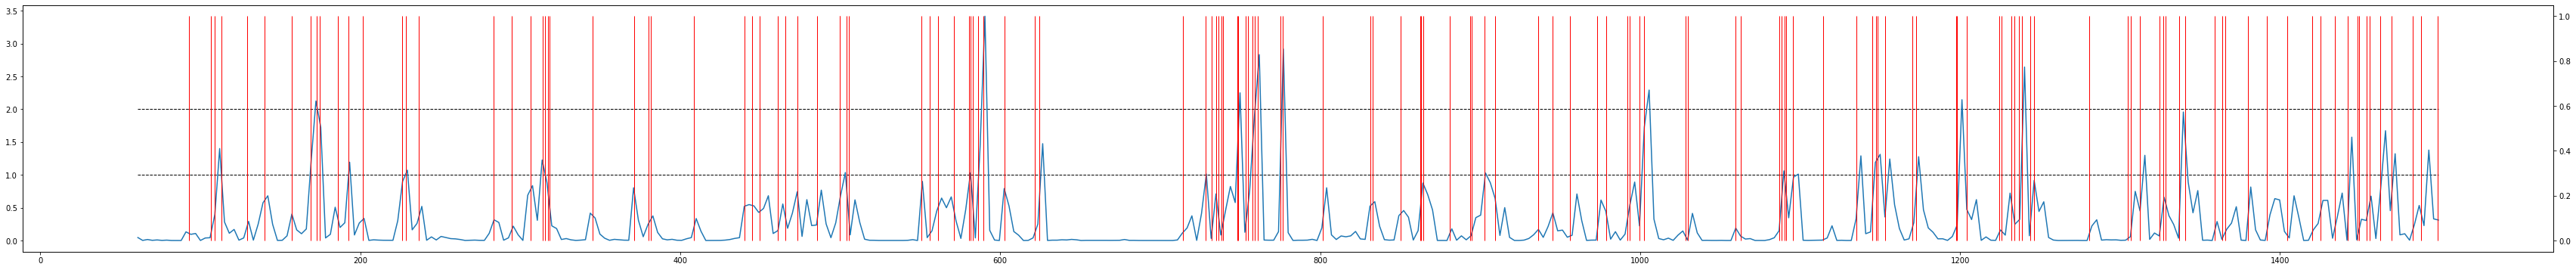

In [8]:
plot_nn_outputs(params.val.time, params.val.events, results)

diff: 2.7804


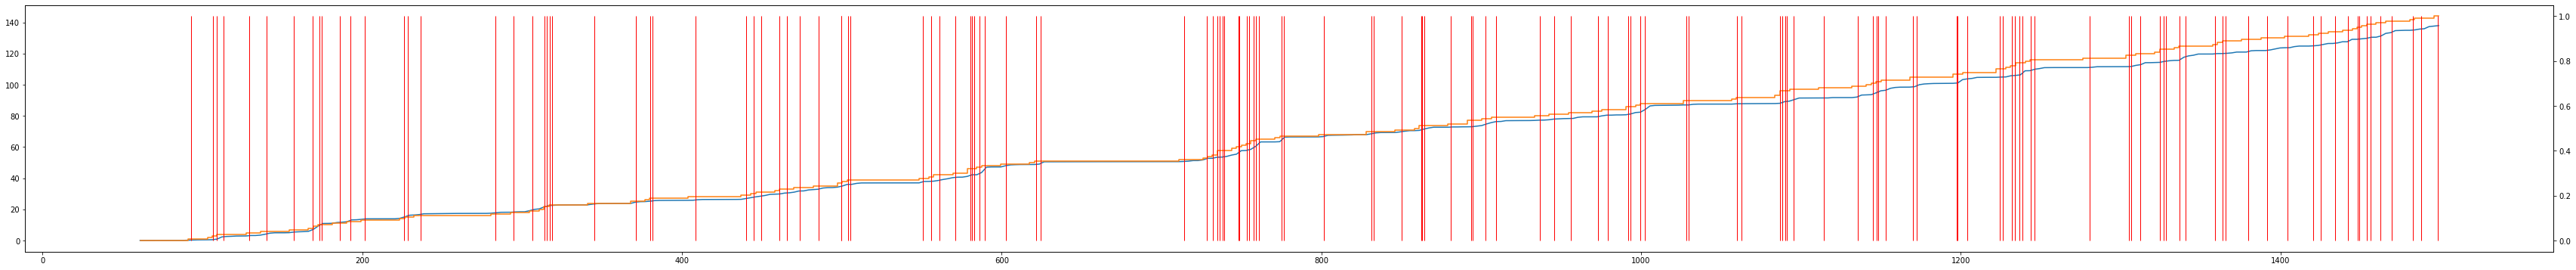

In [9]:
plot_nn_cumsum_2(params.val.time, params.val.events, results)

[87 48 27  7  4  1]


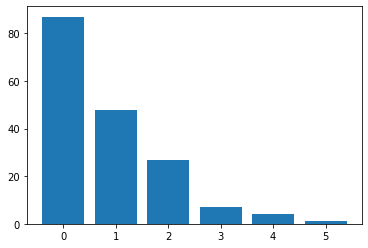

In [10]:
plot_events_density(loader)